## Partial Least Squares Regression

In the last notebook we performed a PCA to extract and explore latent variables (scores) from the data. This time we use PLS to achieve this. PLS seeks to maximize the covariance between X and y.

In [1]:
# load and show dataset
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

/Users/ppp/miniconda2/envs/dlmm-cpu/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load and inspect the housing data. As pointed out in the notebook session on PCR a good choice (in some cases better than integer coding) is one-hot-coding of the categorical variable _ocean_proximiy_. We use ```pandas.get_dummy()``` to generate the variables.

In [2]:
data = pd.read_csv('housing.csv')
data=data.fillna(data.mean())
data = pd.concat((data,pd.get_dummies(data['ocean_proximity'])),axis=1)
print(data.head())
data = data.drop(columns='ocean_proximity')
data.info()

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN  
0          0   

Now we split the data. Use scikit learn's `train_test_split()` function and choose a reasonable test set size. ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['median_house_value'])
y = data.median_house_value
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33)

We will use the sklearn `StandardScaler` object, which standardizes the data such that each column is zero-mean and the standard deviation is 1. In general most of the objects in sklearn provide functions depending on their purpose. In pre-processing this is mainly `.fit()` , `.fit_transform()`,`.transform()`, `.inverse_transform()`. ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))
 
 Remark: We exclude our categorical dummy features from scaling by using the `ColumnTransformer`.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

xscaler = StandardScaler()
yscaler = StandardScaler()
ct = ColumnTransformer([('scaler', xscaler, np.arange(0,8))],remainder='passthrough')
print(X_train.iloc[5:8,7:13])
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)
y_train_scaled = yscaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = yscaler.transform(y_test.values.reshape(-1,1))
print(X_train_scaled[5:8,7:13])

       median_income  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
11165         3.2539          1       0       0         0           0
1757          3.7708          0       0       0         1           0
17588         3.6053          1       0       0         0           0
[[-0.32287063  1.          0.          0.          0.          0.        ]
 [-0.05024221  0.          0.          0.          1.          0.        ]
 [-0.13753183  1.          0.          0.          0.          0.        ]]


In [5]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=12)
pls.fit(X_train_scaled,y_train_scaled)
T_train = pls.x_scores_
data_pls = pd.DataFrame(columns=X_train.columns,data=X_train_scaled.copy())
data_pls[['T1', 'T2', 'T3', 'T4','T5', 'T6','T7', 'T8', 'T9','T10','T11','T12']] = pd.DataFrame(T_train)
data_pls.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.644530  2.314889           -1.321338    -0.591550       -0.567515   
1   1.251774 -1.432722           -1.002886    -0.628624       -0.609923   
2  -0.550926 -0.058442           -1.082499     0.050153        0.012068   
3   0.767392 -0.785450            0.430144    -0.348051       -0.265943   
4   0.607596 -0.672881            1.305885    -0.796144       -0.826678   

   population  households  median_income  <1H OCEAN  INLAND  ...        T3  \
0   -0.874097   -0.852846      -1.121716        0.0     1.0  ...  0.253717   
1    0.155235   -0.527208      -0.615805        0.0     0.0  ... -0.914894   
2   -0.007063    0.111147      -0.308419        1.0     0.0  ... -0.733076   
3   -0.343809   -0.328206      -0.113481        1.0     0.0  ... -1.167682   
4   -0.757798   -0.770144       0.087153        1.0     0.0  ... -1.468972   

         T4        T5        T6        T7        T8        T9       T10  \
0  0.995433 -0.613056 -0.498259 -0.060060 -0.979205  0.073140  0.052419   
1  0.073349 -1.948934 -0.144364  1.215204  0.812581  0.351839  0.114506   
2  0.705730 -0.416808 -0.679904 -0.609990 -0.243897 -0.678214  0.442614   
3 -0.631234  0.182203  0.019500 -0.123724 -0.268980  0.165492 -0.099240   
4 -1.070519  0.512048  0.288918  0.088868 -0.253245  0.005171 -0.039863   

        T11       T12  
0  0.100403  0.098751  
1  0.022756  0.005376  
2 -0.456713 -0.070930  
3  0.034956  0.025226  
4  0.048170 -0.038285  

[5 rows x 25 columns]

__Task:__ Do a scatter plot of the X-Scores of the 1st and 2nd component! Use the median_house_value as hue.

In [6]:
data_pls['median_house_value'] = y_train_scaled
plt.figure()
sns.scatterplot(x='T1',y='T2',hue='median_house_value', data=data_pls)
plt.show()

__Task:__ Try to interpret the plot. Do you find interesting data points? How is the scores relate to the _median_house_value_? What is the difference to the PCA socres plot?

From the plot we can see that the 1st component now looks correlated to the _median_house_value_. This finding is straightforward, as the PLS maxime
izes the covariance. Compare it to the PCR notebook: The component which was (visually) correlated the most with _y_ was the 3rd component. The PLSR find in generel a more compact model than PCR does.

Next, we are interested in how the original features contribute to each of the transformed variables. This can also help to get insights on which of the initial features might be important.

To acount for different magnitudes it is also very common to use the so called _correlation loadings_ instead of the plain loadings. The correlation loadings can either be determined from the loadings itself or by computing the pearson correlaiton between each variable and each score. 

In [7]:
corL = data_pls.corr()
corL.drop(corL.columns[:-13],axis=1,inplace=True)
corL.drop(corL.index[13:],axis=0,inplace=True)
corL

T1        T2        T3        T4        T5  \
longitude           0.097514  0.618673 -0.100807 -0.653755 -0.184176   
latitude           -0.347467 -0.596728  0.221727  0.557944  0.156413   
housing_median_age  0.086987 -0.246943 -0.461139 -0.118117  0.663042   
total_rooms         0.245375  0.506854  0.719072  0.311048  0.132493   
total_bedrooms      0.150703  0.631672  0.600700  0.361175  0.250288   
population          0.153786  0.666771  0.498471  0.417527  0.000741   
households          0.184675  0.634456  0.581155  0.389020  0.227843   
median_income       0.742001 -0.369083  0.421184 -0.239450 -0.145179   
<1H OCEAN           0.533621  0.428635 -0.424379 -0.162951  0.035257   
INLAND             -0.797090 -0.129161  0.499094 -0.213423  0.003270   
ISLAND              0.009575 -0.018042  0.022013 -0.041554 -0.005985   
NEAR BAY            0.164756 -0.399786 -0.144761  0.635494  0.224306   
NEAR OCEAN          0.161978 -0.082557  0.070591 -0.053763 -0.266527   

                          T6        T7        T8        T9       T10  \
longitude           0.075121 -0.044357  0.204842  0.262153 -0.122594   
latitude           -0.003699  0.001212 -0.318593 -0.155370  0.045645   
housing_median_age  0.366964  0.327351  0.141587 -0.001638  0.056512   
total_rooms         0.059774  0.048271 -0.104090  0.132076 -0.009281   
total_bedrooms     -0.099702  0.026025  0.024914  0.041909  0.006203   
population          0.273261  0.077669  0.081007 -0.135531  0.037054   
households         -0.051160  0.024733  0.068169 -0.036027  0.016526   
median_income       0.118055 -0.175097 -0.040358 -0.067906 -0.077859   
<1H OCEAN           0.010763 -0.253882 -0.436272 -0.260254  0.028626   
INLAND              0.161548 -0.148667 -0.006421 -0.029643 -0.062127   
ISLAND              0.076730 -0.221628  0.045088  0.272581  0.919842   
NEAR BAY            0.105483 -0.218548  0.359338  0.351534 -0.158395   
NEAR OCEAN         -0.342244  0.796529  0.319457  0.089353  0.159004   

                         T11       T12  median_house_value  
longitude           0.054138  0.001191           -0.047863  
latitude            0.102454  0.003977           -0.140775  
housing_median_age  0.012717  0.000977            0.095842  
total_rooms        -0.128001 -0.029450            0.131182  
total_bedrooms      0.031602  0.101563            0.047505  
population          0.038308  0.022109           -0.025938  
households          0.065049 -0.093234            0.064303  
median_income       0.020910  0.008185            0.683472  
<1H OCEAN           0.013019  0.000195            0.262031  
INLAND             -0.018153 -0.000769           -0.483441  
ISLAND              0.141017  0.000239            0.015087  
NEAR BAY           -0.035008  0.000103            0.153756  
NEAR OCEAN          0.033592  0.000677            0.139107

In [8]:
sns.scatterplot(x='T1', y='T2', data=corL)
plt.plot(np.sin(np.linspace(0,2*np.pi,100)),np.cos(np.linspace(0,2*np.pi,100)),'--',color='.5')
plt.plot(np.sqrt(0.5)*np.sin(np.linspace(0,2*np.pi,100)),np.sqrt(.5)*np.cos(np.linspace(0,2*np.pi,100)), '--', color='.8')
for kk,nme in enumerate(corL.index):
     plt.annotate(nme,(corL.T1.values[kk]+.01,corL.T2.values[kk]))
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.figure()
sns.scatterplot(x='T1', y='T3', data=corL)
plt.plot(np.sin(np.linspace(0,2*np.pi,100)),np.cos(np.linspace(0,2*np.pi,100)),'--',color='.5')
plt.plot(np.sqrt(0.5)*np.sin(np.linspace(0,2*np.pi,100)),np.sqrt(.5)*np.cos(np.linspace(0,2*np.pi,100)), '--', color='.8')
for kk,nme in enumerate(corL.index):
     plt.annotate(nme,(corL.T1.values[kk]+.01,corL.T3.values[kk]))
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.show()
plt.figure()
sns.scatterplot(x='T2', y='T3', data=corL)
plt.plot(np.sin(np.linspace(0,2*np.pi,100)),np.cos(np.linspace(0,2*np.pi,100)),'--',color='.5')
plt.plot(np.sqrt(0.5)*np.sin(np.linspace(0,2*np.pi,100)),np.sqrt(.5)*np.cos(np.linspace(0,2*np.pi,100)), '--', color='.8')
for kk,nme in enumerate(corL.index):
     plt.annotate(nme,(corL.T2.values[kk]+.01,corL.T3.values[kk]))
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.show()

__Task:__ Try to interpret the plots. What can you say about the different features? Find the correlations between features and principal components. (We will also discuss this in the next lecture)

In analogy to the notebook 2 we want to find the best hyper-parameter for the PLSR using a randomized K-fold. 

__Task:__ Build a Pipeline consisting of a Scaler and a PLSRegression and run the grid search.

Best parameter RMSE=69389.623):
{'plsr__n_components': 12}


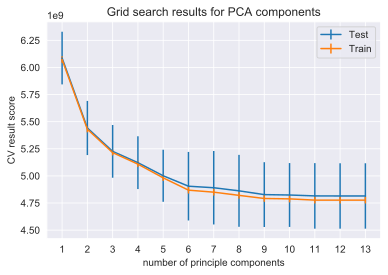

In [9]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler = StandardScaler()
cval = KFold(n_splits=10)
plsr = PLSRegression()
ct = ColumnTransformer([('scaler', scaler, np.arange(0,8))],remainder='passthrough')
##########
#your code goes here:
pipe = Pipeline(steps=[('scaler',ct), ('plsr', plsr)])
param_grid = {'plsr__n_components': range(1,X_train.shape[1]+1)}

##########
search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
print(search.best_params_)

plt.figure()
plt.errorbar(range(1,X_train.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
plt.errorbar(range(1,X_train.shape[1]+1),-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
plt.legend()
plt.xticks(range(1,X_train.shape[1]+1))
plt.xlabel("number of principle components")
plt.ylabel("CV result score")
plt.title("Grid search results for PCA components")
plt.show()

Let us now see what it has been good for:

RMSE training fit: 69124.235
R2 training fit: 0.639 
RMSE prediction: 67903.558
R2 prediction: 0.658 


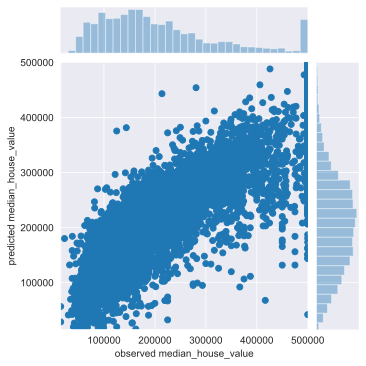

In [10]:
best_estimator = search.best_estimator_
y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

minlim = y_test.min()
maxlim = y_test.max()
# predicted/actual plot for test set
ax = sns.jointplot(x=y_test.ravel(),y=y_pred_test.ravel(), height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
ax.ax_joint.set_xlabel('observed median_house_value')
ax.ax_joint.set_ylabel('predicted median_house_value')
plt.show()

We can observe that the PLSR is able to be effective with less components than the PCR. But for this particular dataset we can not really improve the predictive power neither with PCR nor with PLSR (in terms of test error). Nontheless we see that we can have a more compact model (i.e. 6 components) with PLSR if we sacrifice a little bit of the predictive power. 

The advantage of PLS is more prominent when dealing with a matrix _Y_ of dependent variables, which is not the case for the chosen dataset.